# Quantifying IAP type & phylogeny between different CTCF clusterings

In [117]:
import pybedtools
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
iap_type_bed = pybedtools.BedTool("data/feature_beds/mm10.IAP.mended.bed")
iap_dataset_bed = pybedtools.BedTool("data/clean_beds/mm10.IAP.mended.extent.bed")
structure_df = pd.read_csv("data/mm10.IAP.structures.tsv", sep='\t', header=0)

In [4]:
# Obtaining sequence files:
fasta = "data/GRCm38.p6.genome.fa"
filtered_dataset = iap_dataset_bed.filter(lambda x: len(x) < 2000)
filtered_dataset = filtered_dataset.sequence(fi=fasta)
filtered_dataset.save_seqs("data/iap_sequence.fa")

<BedTool(<generator object BedTool.filter.<locals>.<genexpr> at 0x11f8aeed0>)>

In [5]:
intersect_bed = iap_dataset_bed.intersect(iap_type_bed, wao=True, s=True, f=0.8).saveas()
names = ["chrom", "start", "end", "element_id",
         "length", "strand", "chrom1", "start1", "end1", "iap_type",
         "uh", "strand1", "overlap"]
intersect_df = intersect_bed.to_dataframe(names=names)
intersect_df.index = intersect_df["element_id"].astype(int).to_list()
intersect_df.index.value_counts()

2528578    1
2782692    1
245197     1
304590     1
3550671    1
          ..
2681624    1
3115804    1
4022696    1
3685096    1
571956     1
Length: 8059, dtype: int64

In [6]:
cluster_df = pd.read_pickle("data/iap_clustered.pkl")

In [122]:
structure_df.index = structure_df["element.ID"].astype(int).to_list()
structure_df["optimal.structure"].value_counts()

IAPLTR1a_Mm – IAPEz-int              751
IAPLTR1_Mm – IAPEz-int               650
IAPEY2_LTR                           638
IAPLTR2a2_Mm                         636
IAPLTR2b                             627
                                    ... 
IAPEY5_LTR|IAPEY5_I-int|IAP-d-int      1
IAPEY3-int|RLTR10C                     1
IAPLTR2a2_Mm|IAPA_MM-int               1
RLTR10E|IAPEY3-int                     1
RLTR46A2 – IAPEY4_I-int                1
Name: optimal.structure, Length: 265, dtype: int64

In [8]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]
label_order = ["A", "B", "C", "D", "E"]

In [123]:
cluster_df["iap_type"] = structure_df["optimal.structure"].copy()
cluster_df

,chrom,start,end,element_id,length,strand,val_result,cluster_assignments,iap_type
28,chr1,3031358,3031710,28,353,-,-1,B,IAPLTR1a_Mm
182,chr1,3143092,3148151,182,5060,-,-1,B,IAPEY2_LTR – IAPEy-int
1272,chr1,3997836,3998160,1272,325,-,-1,B,IAPLTR2b
1427,chr1,4132179,4132516,1427,338,-,-1,B,IAPLTR1a_Mm
1976,chr1,4556987,4559597,1976,2611,-,-1,D,IAPEz-int|IAPEY4_I-int|IAPEz-int|IAPLTR2_Mm
...,...,...,...,...,...,...,...,...,...
4245666,chr9,123742716,123749810,4245666,7095,-,Tissue-specific,B,IAPLTR1_Mm – IAPEz-int
4245722,chr9,123783363,123788707,4245722,5345,+,-1,B,IAPLTR4_I|IAPEY3-int|IAPLTR4_I
4246111,chr9,124080169,124082990,4246111,2822,+,Tissue-specific,B,IAPEY_LTR|IAPEy-int|IAPEY3-int
4246418,chr9,124376688,124378655,4246418,1968,-,-1,D,IAPLTR3-int|IAPLTR4


In [94]:
normalised_counts_dataframe = pd.DataFrame(columns=label_order)
for label in label_order:
    clus_assign = cluster_df.loc[cluster_df["cluster_assignments"] == label, :]
    number = clus_assign.shape[0]
    counts = clus_assign["iap_type"].value_counts().sort_index()
    normalised_counts = counts.apply(lambda x: x / number)
    normalised_counts_dataframe[label] = normalised_counts

[(0, 0.2)]

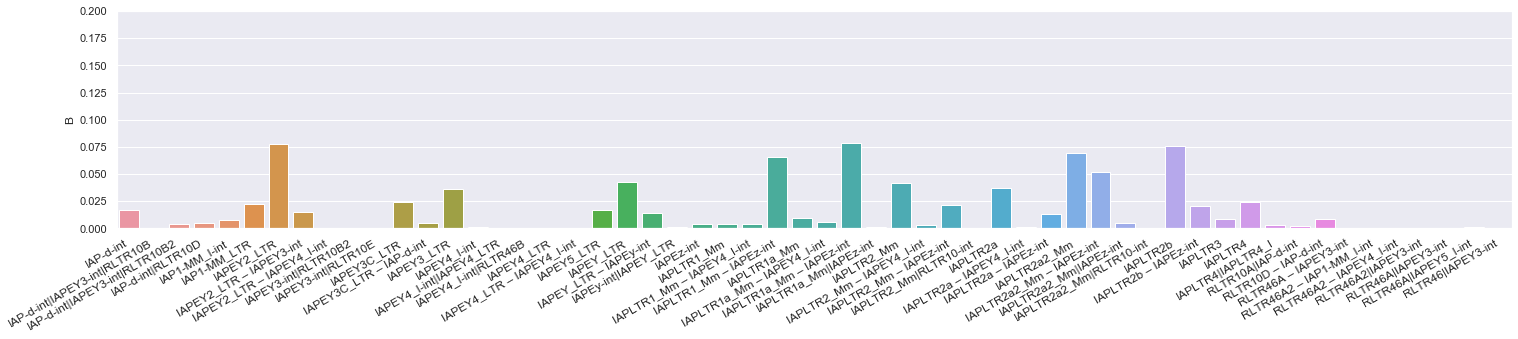

In [200]:
matplotlib.rcParams['figure.figsize'] = [25, 4]
ax = sns.barplot(x=normalised_counts_dataframe.index, y=normalised_counts_dataframe["B"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12, horizontalalignment='right')

ax.set(ylim=(0, 0.2))

In [121]:
normalised_counts_dataframe = normalised_counts_dataframe.fillna(0)

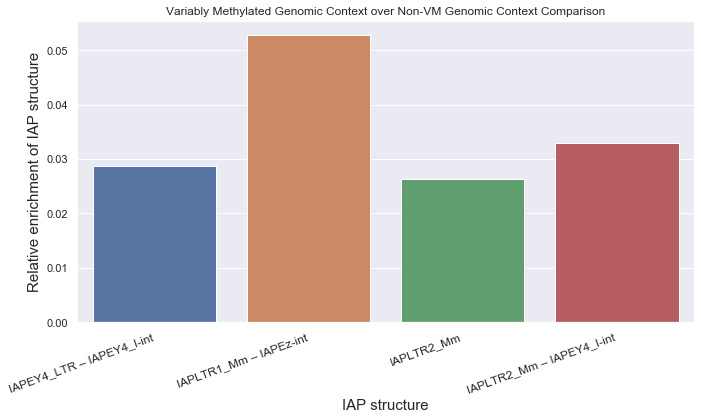

In [120]:
# Generating comparison data:
ac_counts = (normalised_counts_dataframe["A"] + normalised_counts_dataframe["C"])/2
bde_counts = (
        normalised_counts_dataframe["B"] + normalised_counts_dataframe["D"] + normalised_counts_dataframe["E"])/3
methyl_comparison = ac_counts - bde_counts
methyl_comparison = methyl_comparison[np.abs(methyl_comparison) > 0.025]

# Setting plot options:
matplotlib.rcParams['figure.figsize'] = [10, 6]
sns.set()

# Plotting comparison:
ax = sns.barplot(x=methyl_comparison.index,
                 y=methyl_comparison)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, fontsize=12, horizontalalignment='right')
ax.set_ylabel('Relative enrichment of IAP structure', fontsize=15)
ax.set_xlabel('IAP structure', fontsize=15)
# ax.set(ylim=(-0.2, 0.2))
ax.set_title("Variably Methylated Genomic Context over Non-VM Genomic Context Comparison")

# Saving figures:
plt.tight_layout()
plt.savefig("plots/iap_structure_enrichment.png", dpi=200)
plt.savefig("plots/iap_structure_enrichment.pdf")

In [162]:
cluster_df["cluster_assignments"].value_counts().sort_index()

A     638
B    5519
C     254
D    1182
E     466
Name: cluster_assignments, dtype: int64

In [177]:
pyroval_bed = pybedtools.BedTool("data/IAP_validation.July2019.stranded.with_IDs.bed")
names = ["chrom", "start", "end", "strand", "gene",
         "blueprint", "ear", "b_cell", "val_status", "element_id"]
pyroval_df = pyroval_bed.to_dataframe(names=names)
pyroval_df = pyroval_df[pyroval_df["ear"].notnull()]
pyroval_df = pyroval_df[pyroval_df["element_id"] != "."]
pyroval_df = pyroval_df[pyroval_df["chrom"] != "chrX"]

pyroval_df.index = pyroval_df["element_id"].astype(int).to_list()

In [163]:
cluster_df["ear"] = pyroval_df["ear"]
blueprint_categories = cluster_df[cluster_df.ear.notnull()]
blueprint_categories["cluster_assignments"].value_counts(sort=False).sort_index()

A    27
B    14
C    40
D     9
E     3
Name: cluster_assignments, dtype: int64

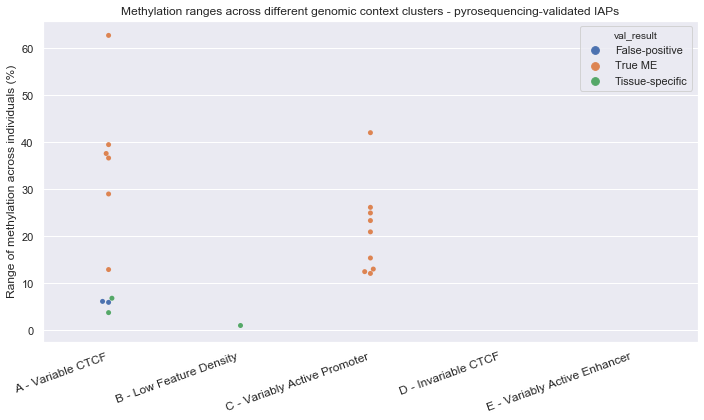

In [152]:
hue_order = ["A", "B", "C", "D", "E"]

matplotlib.rcParams['figure.figsize'] = [10, 6]
ax = sns.swarmplot(x="cluster_assignments", y="ear", hue="val_result", order=hue_order, data=blueprint_categories)
ax.set(xticklabels=["A - Variable CTCF", "B - Low Feature Density",
                    "C - Variably Active Promoter", "D - Invariable CTCF",
                    "E - Variably Active Enhancer"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, fontsize=12, horizontalalignment='right')
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Range of methylation across individuals (%)", fontsize=12)
ax.set_title("Methylation ranges across different genomic context clusters - pyrosequencing-validated IAPs")

In [153]:
methylation_df = pd.read_csv("data/IAP_LTR.blueprint_methy_ranges.tsv", sep='\t', header=0)
methylation_df = methylation_df.loc[methylation_df["edge"] == "5'", :]
methylation_df.index = methylation_df["element.ID"].astype(int).to_list()
methylation_df

,element.ID,side,B.range1,B.range2,T.range1,T.range2,mean1,mean2,strand,edge
28,28,right,0.089552,0.052910,0.040000,0.021970,0.064776,0.037440,-,5'
182,182,right,0.064516,0.044556,0.071429,0.032762,0.067972,0.038659,-,5'
1272,1272,right,0.066227,0.033333,0.127473,0.048485,0.096850,0.040909,-,5'
1427,1427,right,0.083333,0.073171,0.054054,0.031438,0.068694,0.052304,-,5'
1979,1979,right,0.053571,0.038462,0.108696,0.081633,0.081134,0.060047,-,5'
...,...,...,...,...,...,...,...,...,...,...
4485669,4485669,left,NaN,NaN,0.107143,0.030242,NaN,NaN,+,5'
4485754,4485754,right,NaN,NaN,0.100000,0.055556,NaN,NaN,-,5'
4498998,4498998,right,NaN,NaN,0.127660,0.018169,NaN,NaN,-,5'
4503009,4503009,right,NaN,NaN,0.047619,0.029412,NaN,NaN,-,5'


In [169]:
cluster_df["b_range"] = methylation_df["B.range2"] * 100
cluster_df["t_range"] = methylation_df["T.range2"] * 100
cluster_df["mean_range"] = methylation_df["mean2"] * 100

label_order = ["A", "B", "C", "D", "E"]

In [173]:
bool_mask = (cluster_df["iap_type"] == "IAPEY4_LTR – IAPEY4_I-int") | \
            (cluster_df["iap_type"] == "IAPLTR1_Mm – IAPEz-int") | \
            (cluster_df["iap_type"] == "IAPLTR2_Mm") | \
            (cluster_df["iap_type"] == "IAPLTR2_Mm – IAPEY4_I-int")
interest_structure_df = cluster_df[bool_mask]
interest_structure_df["iap_type"].value_counts()

IAPLTR1_Mm – IAPEz-int       596
IAPLTR2_Mm                   441
IAPLTR2_Mm – IAPEY4_I-int     97
IAPEY4_LTR – IAPEY4_I-int     20
Name: iap_type, dtype: int64

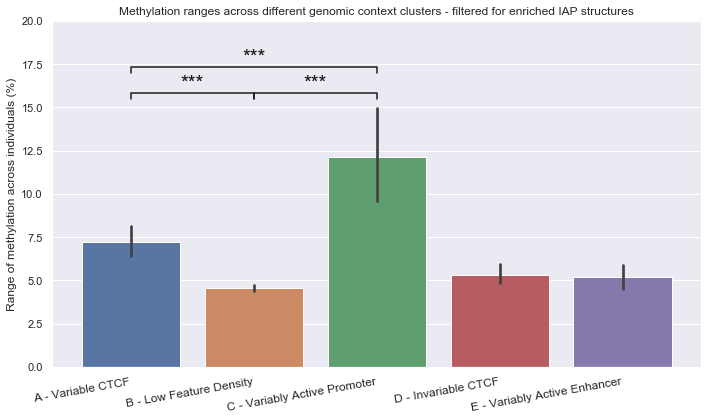

In [207]:
# Setting plot options:
matplotlib.rcParams['figure.figsize'] = [10, 6]

# Plotting figure:
ax = sns.barplot(x="cluster_assignments", y="t_range",
                 order=label_order, data=interest_structure_df)
ax.set(xticklabels=["A - Variable CTCF", "B - Low Feature Density",
                    "C - Variably Active Promoter", "D - Invariable CTCF",
                    "E - Variably Active Enhancer"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=12, horizontalalignment='right')
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Range of methylation across individuals (%)", fontsize=12)
ax.set(ylim=(0, 20))
ax.set_title("Methylation ranges across different genomic context clusters - filtered for enriched IAP structures")

# Statistical annotation 1:
x1, x2 = 0, 1  
y, h, col = 15.5, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=20)

# Statistical annotation 2:
x1, x2 = 1, 2
y, h, col = 15.5, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=20)

# Statistical annotation 3:
x1, x2 = 0, 2
y, h, col = 17, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=20)

# Saving figure:
plt.tight_layout()
plt.savefig("plots/filtered_methylation_barplot.png", dpi=200)
plt.savefig("plots/filtered_methylation_barplot.pdf")

In [203]:
import scipy.stats as stats
# p-value for 3 comparisons 0.166
stats.ttest_ind(interest_structure_df['t_range'][interest_structure_df['cluster_assignments'] == 'B'],
                interest_structure_df['t_range'][interest_structure_df['cluster_assignments'] == 'C'],
                nan_policy='omit')

Ttest_indResult(statistic=-14.37515204116719, pvalue=6.542568955574067e-41)

In [191]:
iap_untested = interest_structure_df[interest_structure_df["val_result"] == "-1"].copy()
iap_untested

,chrom,start,end,element_id,length,strand,val_result,cluster_assignments,iap_type,ear,b_range,t_range,mean_range
3347,chr1,5367996,5368484,3347,489,+,-1,B,IAPLTR2_Mm,NaN,9.586466,6.692345,8.139405
4398,chr1,6168109,6172813,4398,4705,+,-1,B,IAPLTR1_Mm – IAPEz-int,NaN,5.405405,2.791461,4.098433
12739,chr1,11965176,11965731,12739,556,-,-1,B,IAPLTR2_Mm,NaN,6.451613,2.739726,4.595669
17349,chr1,14831640,14832203,17349,564,-,-1,D,IAPLTR2_Mm,NaN,3.448276,2.272727,2.860502
20419,chr1,16702087,16702603,20419,517,-,-1,D,IAPLTR2_Mm,NaN,4.255319,2.962963,3.609141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240278,chr9,121024681,121029476,4240278,4796,+,-1,E,IAPLTR1_Mm – IAPEz-int,NaN,2.380952,3.342953,2.861953
4240827,chr9,121322377,121328483,4240827,6107,-,-1,B,IAPLTR1_Mm – IAPEz-int,NaN,19.362745,5.882353,12.622549
4242814,chr9,122401676,122408740,4242814,7065,-,-1,B,IAPLTR1_Mm – IAPEz-int,NaN,4.000000,2.564103,3.282051
4242911,chr9,122457458,122457875,4242911,418,-,-1,B,IAPLTR2_Mm,NaN,4.420334,4.976415,4.698374


Text(0.5, 1.0, 'Methylation ranges across different genomic context clusters - filtered for IAPLTR1_Mm – IAPEz-int')

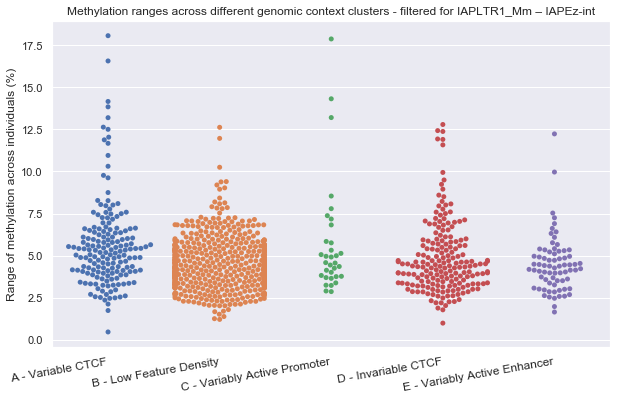

In [196]:
# Setting plot options:
matplotlib.rcParams['figure.figsize'] = [10, 6]

# Plotting figure:
ax = sns.swarmplot(x="cluster_assignments", y="mean_range",
                 order=label_order, data=iap_untested)
ax.set(xticklabels=["A - Variable CTCF", "B - Low Feature Density",
                    "C - Variably Active Promoter", "D - Invariable CTCF",
                    "E - Variably Active Enhancer"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=12, horizontalalignment='right')
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Range of methylation across individuals (%)", fontsize=12)
#ax.set(ylim=(0, 70))
ax.set_title("Methylation ranges across different genomic context clusters - filtered for IAPLTR1_Mm – IAPEz-int")

In [199]:
bool_mask = ((iap_untested["cluster_assignments"] == 'A') | \
            (iap_untested["cluster_assignments"] == 'C')) &  \
            (iap_untested["t_range"] > 10)
new_candidates_df = iap_untested[bool_mask].copy()
new_candidates_df.iap_type.value_counts()

IAPLTR1_Mm – IAPEz-int       11
IAPLTR2_Mm                    5
IAPLTR2_Mm – IAPEY4_I-int     4
IAPEY4_LTR – IAPEY4_I-int     3
Name: iap_type, dtype: int64

In [208]:
new_candidates_df.shape

(23, 13)